In [1]:
import sys
# adding search_optimization_tools to the system path
sys.path.insert(0, '../')

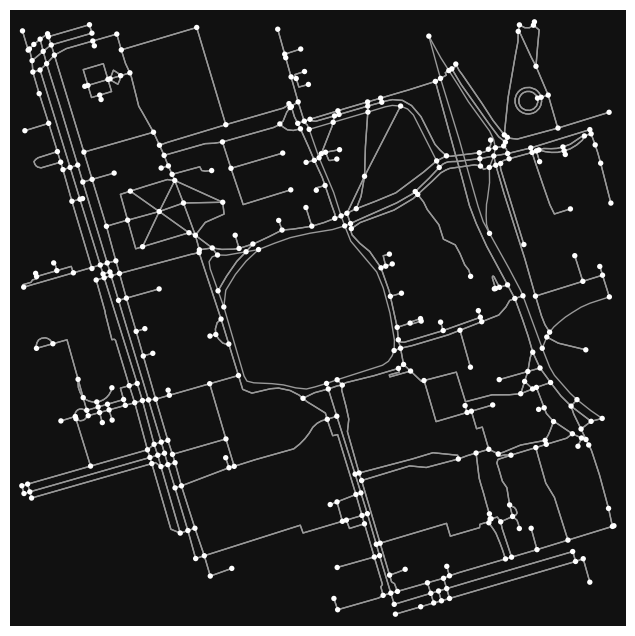

In [2]:
# Contraction Hierarchy

from sys import getsizeof
from time import process_time
import osmnx
import networkx as nx
from search_optimization_tools.routing import cost, draw_route
from search_optimization_tools.structures import Node, Solution

osmnx.settings.log_console = True
osmnx.settings.use_cache = True

reference = (43.661667, -79.395)

"""G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True, network_type="drive")
origin = Node(G, 36603405)
destination = Node(G, 24959556)"""

G = osmnx.graph_from_point(reference, dist=300, clean_periphery=True, simplify=True)
origin = Node(G, 55808290)
destination = Node(G, 389677909)

osmnx.plot_graph(G)
orig_G = G.copy()


In [3]:
# Step 1: Remove Parallels and Loops, because Dijkstra doesn't like that
clean_G = G.copy()
clean_G.clear_edges()
for u in G.nodes:
    for v in G[u]:
        if u == v: continue # Remove self loops
        if len(G[u][v]) > 1:
            keep = min(G[u][v], key=lambda x:G[u][v][x]['length'])
            keep = G[u][v][keep]
            clean_G.add_edge(u,v,**keep)
            continue
        clean_G.add_edge(u,v,**G[u][v][0])

G = clean_G

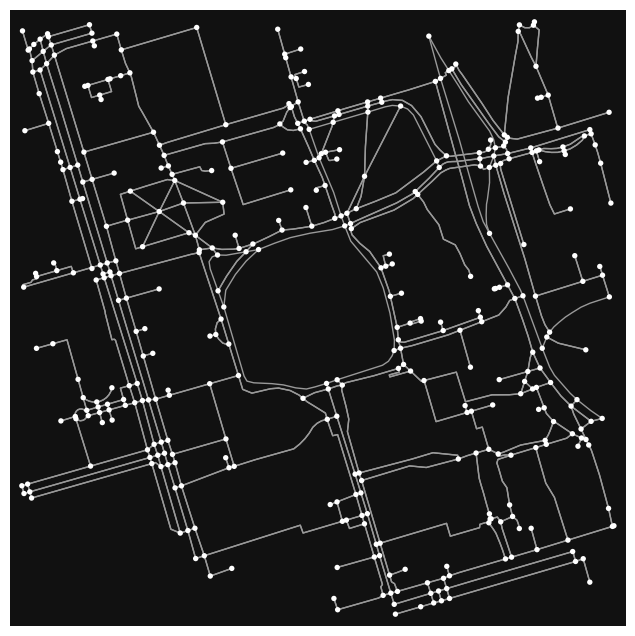

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [4]:
osmnx.plot_graph(G)

In [5]:
def edge_differences(G, sp):
    edge_difference = {}
    degrees = dict(G.degree)
    for node in G.nodes:
        req_edges = 0
        neighbours = list(G.neighbors(node))

        # Some nodes are deadends. The ED for these nodes is just the degree.
        if len(neighbours)==0: edge_difference[node] = - degrees[node]

        for u, v in G.in_edges(node):
            for v, w in G.out_edges(node):
                if u == w: continue # Two way edge, ignore this
                if v in sp[u][w]:
                    req_edges += 1
        
        edge_difference[node] = req_edges - degrees[node]


    return dict(sorted(edge_difference.items(), key=lambda x: x, reverse=True))
    

In [6]:
# Using functions from smart_mobility_utilities, we can generate shortest paths and edge differences very quickly

sp = dict(nx.all_pairs_dijkstra_path(G, weight="length"))
ed = edge_differences(G,sp)
hierarchical_order = {node: order for order, node in enumerate(reversed(ed))}

In [7]:
from copy import deepcopy
from tqdm.notebook import tqdm
def contract_graph(G, ed, cost_fn):
    contracted = 0
    start_time = process_time()

    master_dij= master_copy= master_loop = 0
    for node in tqdm(ed):
        current_G = deepcopy(G)
        current_G.remove_node(node)
        for u, v in G.in_edges(node):
            for v, w in G.out_edges(node):
                if u == w: continue # Two way edge, ignore this
                sp = nx.dijkstra_path(G,u,w,weight="length")
                if v in sp:
                    G.add_edge(u,w, length=cost_fn(G, sp), midpoint=v)
                    contracted += 1
    
    end_time = process_time()
    space_required = getsizeof(G) - getsizeof(orig_G)
    return Solution(G, end_time-start_time, space_required, contracted)


In [8]:
preprocess_sln = contract_graph(G, ed, cost)
G = preprocess_sln.result
print(f"Preprocessing time: {preprocess_sln.time} s")
print(f"Preprocessing Space: {preprocess_sln.space} bytes")
print(f"Shortcut edges added Explored: {preprocess_sln.explored}")
#nx.write_gpickle(G, "service.gpickle")

  0%|          | 0/406 [00:00<?, ?it/s]

Preprocessing time: 127.0 s
Preprocessing Space: 0 bytes
Shortcut edges added Explored: 5549


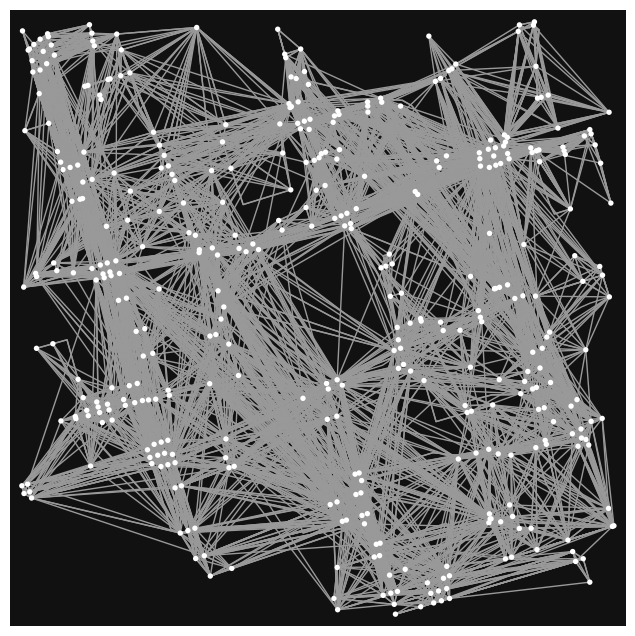

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [9]:
osmnx.plot_graph(G)

In [10]:
def _weight_function(G, weight):
    if callable(weight):
        return weight
    # If the weight keyword argument is not callable, we assume it is a
    # string representing the edge attribute containing the weight of
    # the edge.
    if G.is_multigraph():
        return lambda u, v, d: min(attr.get(weight, 1) for attr in d.values())
    return lambda u, v, data: data.get(weight, 1)

In [11]:
import math
from itertools import count
from heapq import heappush, heappop

def bidirectional_dijkstra(G, source, target, hierarchy = None, weight="weight"):
    start_time = process_time()
    space_req = 0
    if source not in G or target not in G:
        msg = f"Either source {source} or target {target} is not in G"
        raise nx.NodeNotFound(msg)

    if source == target:
        return (0, [source])

    weight = _weight_function(G, weight)
    push = heappush
    pop = heappop
    # Init:  [Forward, Backward]
    dists = [{}, {}]  # dictionary of final distances
    paths = [{source: [source]}, {target: [target]}]  # dictionary of paths
    fringe = [[], []]  # heap of (distance, node) for choosing node to expand
    seen = [{source: 0}, {target: 0}]  # dict of distances to seen nodes
    c = count()
    # initialize fringe heap
    push(fringe[0], (0, next(c), source))
    push(fringe[1], (0, next(c), target))
    # neighs for extracting correct neighbor information
    if G.is_directed():
        neighs = [G._succ, G._pred]
    else:
        neighs = [G._adj, G._adj]
    # variables to hold shortest discovered path
    # finaldist = 1e30000
    finalpath = []
    dir = 1
    while fringe[0] or fringe[1]:
        # choose direction
        # dir == 0 is forward direction and dir == 1 is back
        dir = 1 - dir
        if not fringe[dir]: dir = 1 - dir
        # extract closest to expand
        (dist, _, v) = pop(fringe[dir])

        if v in dists[dir]:
            # Shortest path to v has already been found
            continue
        # update distance
        dists[dir][v] = dist  # equal to seen[dir][v]
        if v in dists[1 - dir]:
            # if we have scanned v in both directions we are done
            # we have now discovered the shortest path
            end_time = process_time()
            return Solution(finalpath, end_time-start_time, space_req, len(seen[0])+len(seen[1]))

        for w, d in neighs[dir][v].items():
            # weight(v, w, d) for forward and weight(w, v, d) for back direction
            cost = weight(v, w, d) if dir == 0 else weight(w, v, d)
            if cost is None:
                continue
            vwLength = dists[dir][v] + cost
            if w not in seen[dir] or vwLength < seen[dir][w]:
                if hierarchy:
                    if hierarchy[v] > hierarchy[w]: continue
                
                # relaxing
                seen[dir][w] = vwLength
                push(fringe[dir], (vwLength, next(c), w))
                space_req = max(space_req, getsizeof(fringe))
                paths[dir][w] = paths[dir][v] + [w]
                if w in seen[0] and w in seen[1]:
                    # see if this path is better than the already
                    # discovered shortest path
                    totaldist = seen[0][w] + seen[1][w]
                    if finalpath == [] or finaldist > totaldist:
                        finaldist = totaldist
                        revpath = paths[1][w][:]
                        revpath.reverse()
                        finalpath = paths[0][w] + revpath[1:]
    print(finalpath)
    raise nx.NetworkXNoPath(f"No path between {source} and {target}.")

In [12]:
solution = bidirectional_dijkstra(G, origin.osmid, destination.osmid, hierarchical_order, weight="length")
print(solution)
print(f"Process Time: {solution.time}")
print(f"Space Req: {solution.space}")
print(f"Explored nodes: {solution.explored}")

Process Time: 0.015625
Space Req: 72
Explored nodes: 166


In [13]:
def unpack(G, u,v):
    u = int(u)
    v = int(v)
    if "midpoint" in G[u][v][0]:
        midpoint = G[u][v][0]["midpoint"]
        return unpack(G,u,midpoint) + unpack(G,midpoint, v)
    return [u]

In [14]:
print(solution.result)

[55808290, 389677953, 2143488335, 2480712846, 9135892695, 5098988924, 854322047, 389677909]


In [15]:
route = []
for u,v in zip(solution.result[:-1], solution.result[1:]):
    route.extend(unpack(G,u,v))
route += [solution.result[-1]]
print(route)

[55808290, 304891685, 1721866234, 9270977970, 3179025274, 4953810914, 55808233, 299625330, 389677953, 2143488335, 389677947, 2143489692, 2480712846, 389678140, 389678139, 783622470, 9135892695, 783622470, 389678139, 389678138, 3707407638, 6028561924, 5098988924, 389678131, 6028562356, 854322047, 389677908, 749952029, 389677909]


In [16]:
cost(G, route)

1029.28

In [17]:
r = nx.dijkstra_path(G, origin.osmid, destination.osmid, weight="length")

In [18]:
draw_route(G, route)